# ***Bayes Classifier and Boosting***

## Imports

In [10]:
import numpy as np
from scipy import misc
from importlib import reload
from utils import *
import random

## 1) Bayes classifier

In [13]:
def computePrior(labels, W=None):
    """
    in: labels - N vector of class labels
    out: prior - C x 1 vector of class priors
    """
    Npts = labels.shape[0]
    if W is None:
        W = np.ones((Npts,1))/Npts
    else:
        assert(W.shape[0] == Npts)
    
    classes = np.unique(labels)
    Nclasses = np.size(classes)

    prior = np.zeros((Nclasses,1))

    for k in range(Nclasses):
        W_i = W[labels == k] # weights for class k
        prior[k] = sum(W_i)
    
    return prior

def mlParams(X, labels, W=None):
    """
    OBJECTIVE: estimate the parameters by those maximizing likelihood
    in:      X - N x d matrix of N data points
        labels - N vector of class labels
    out:    mu - C x d matrix of class means (mu[i] - class i mean)
         sigma - C x d x d matrix of class covariances (sigma[i] - class i sigma)
    """
    assert(X.shape[0]==labels.shape[0])
    Npts,Ndims = np.shape(X)
    classes = np.unique(labels)
    Nclasses = np.size(classes)

    if W is None:
        W = np.ones((Npts,1))/float(Npts) # uniform distrib ie MLE

    mu = np.zeros((Nclasses,Ndims))
    sigma = np.zeros((Nclasses,Ndims,Ndims))

    for k in range(Nclasses):
        W_i = W[labels == k] # weights for class k
        mu[k] = sum(X[labels == k] * W_i) / sum(W_i)
        
    for k in range(Nclasses):
        X_i = X[labels == k] # samples from class k
        W_i = W[labels == k] # weights for class k
        # variance for each dimension m
        diff = X_i - mu[k]  # substract the mean of class k using broadcasting
        variances = np.sum(W_i * (diff ** 2), axis=0) / sum(W_i)  # weighted variance for each dimension m (we use np.sum because it is a matrix)
        np.fill_diagonal(sigma[k], variances) # only for diagonal

    return mu, sigma

def classifyBayes(X, prior, mu, sigma):
    """
    in:      X - N x d matrix of M data points
         prior - C x 1 matrix of class priors
            mu - C x d matrix of class means (mu[i] - class i mean)
         sigma - C x d x d matrix of class covariances (sigma[i] - class i sigma)
    out:     h - N vector of class predictions for test points
    """

    Npts = X.shape[0]
    Nclasses,Ndims = np.shape(mu)
    logProb = np.zeros((Nclasses, Npts))

    for k in range(Nclasses):
        # for diagonal sigma, determinant is product of diagonal elements
        term_1 = -0.5 * np.sum(np.log(np.diag(sigma[k])))
        
        # calculate difference matrix for all points at once
        diff = X - mu[k]  # this broadcasts mu[k] to match X's shape
        
        # for diagonal sigma, inverse multiply is just division by diagonal elements
        # calculate for all dimensions at once
        inv_sigma = 1.0 / np.diag(sigma[k])
        
        # vectorized computation of term_2 for all points
        term_2 = -0.5 * np.sum(diff**2 * inv_sigma, axis=1)
        
        term_3 = np.log(prior[k])
        
        # Assign log probabilities for class k
        logProb[k] = term_1 + term_2 + term_3
    
    # Find class
    h = np.argmax(logProb,axis=0)
    return h

In [15]:
class BayesClassifier(object):
    def __init__(self):
        self.trained = False

    def trainClassifier(self, X, labels, W=None):
        rtn = BayesClassifier()
        rtn.prior = computePrior(labels, W)
        rtn.mu, rtn.sigma = mlParams(X, labels, W)
        rtn.trained = True
        return rtn

    def classify(self, X):
        return classifyBayes(X, self.prior, self.mu, self.sigma)

## Test the Maximum Likelihood estimates

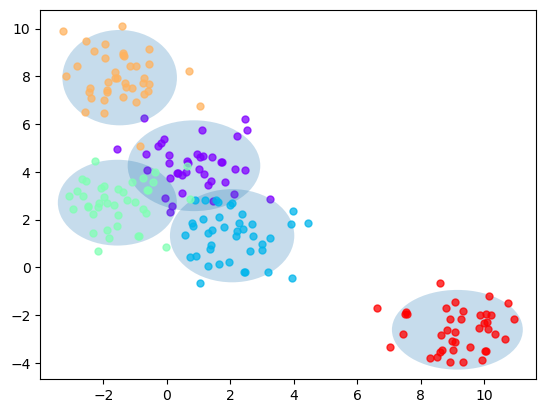

In [11]:
%matplotlib inline

X, labels = genBlobs(centers=5) # 5 classes
mu, sigma = mlParams(X,labels)
plotGaussian(X,labels,mu,sigma)

In [17]:
testClassifier(BayesClassifier(), dataset='iris', split=0.7)

Trial: 0 Accuracy 84.4
Trial: 10 Accuracy 95.6
Trial: 20 Accuracy 93.3
Trial: 30 Accuracy 86.7
Trial: 40 Accuracy 88.9
Trial: 50 Accuracy 91.1
Trial: 60 Accuracy 86.7
Trial: 70 Accuracy 91.1
Trial: 80 Accuracy 86.7
Trial: 90 Accuracy 91.1
Final mean classification accuracy  89 with standard deviation 4.16


In [37]:
testClassifier(BayesClassifier(), dataset='vowel', split=0.7)

Trial: 0 Accuracy 61
Trial: 10 Accuracy 66.2
Trial: 20 Accuracy 74
Trial: 30 Accuracy 66.9
Trial: 40 Accuracy 59.7
Trial: 50 Accuracy 64.3
Trial: 60 Accuracy 66.9
Trial: 70 Accuracy 63.6
Trial: 80 Accuracy 62.3
Trial: 90 Accuracy 70.8
Final mean classification accuracy  64.7 with standard deviation 4.03


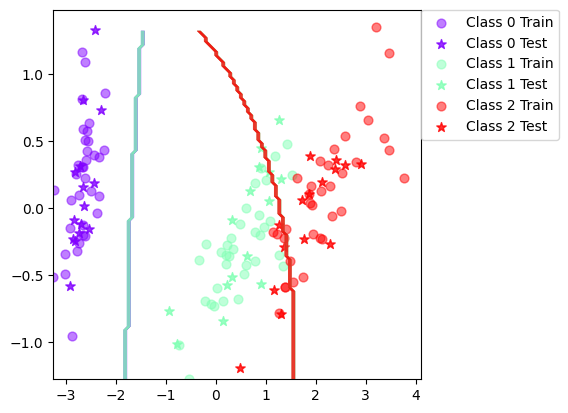

In [4]:
%matplotlib inline
plotBoundary(BayesClassifier(), dataset='iris',split=0.7)

## 2) Boosting

In [39]:
def trainBoost(base_classifier, X, labels, T=10):
    """
    in: base_classifier - a classifier of the type that we will boost, e.g. BayesClassifier
                      X - N x d matrix of N data points
                 labels - N vector of class labels
                      T - number of boosting iterations
    out:    classifiers - (maximum) length T Python list of trained classifiers
                 alphas - (maximum) length T Python list of vote weights
    """
    # these will come in handy later on
    Npts,Ndims = np.shape(X)

    classifiers = [] # append new classifiers to this list
    alphas = [] # append the vote weight of the classifiers to this list

    # The weights for the first iteration
    wCur = np.ones((Npts,1))/float(Npts)

    for i_iter in range(0, T):
        # a new classifier can be trained like this, given the current weights
        classifiers.append(base_classifier.trainClassifier(X, labels, wCur))

        # do classification for each point
        vote = classifiers[-1].classify(X)

        # computing error of the classifier
        mask = (vote != labels) # boolean giving wrong votes
        eps = sum(wCur[mask]) # we sum only when wrong vote
        
        # computing vote weight of the classifier
        eps = np.clip(eps, 1e-10, 1 - 1e-10) # to avoid log(0)
        alpha = 0.5 * (np.log(1-eps) - np.log(eps))
        alphas.append(alpha)

        # updating weights
        wCur[mask] *= np.exp(alpha) # wrongs
        wCur[~mask] *= np.exp(-alpha) # rights
        wCur /= sum(wCur) # normalization
        
    return classifiers, alphas

def classifyBoost(X, classifiers, alphas, Nclasses):
    """
    in:       X - N x d matrix of N data points
    classifiers - (maximum) length T Python list of trained classifiers as above
         alphas - (maximum) length T Python list of vote weights
       Nclasses - the number of different classes
    out:  yPred - N vector of class predictions for test points
    """
    Npts = X.shape[0]
    Ncomps = len(classifiers)

    # if we only have one classifier, we may just classify directly
    if Ncomps == 1:
        return classifiers[0].classify(X)
    else:
        votes = np.zeros((Npts,Nclasses))

        for t in range(Ncomps):
            vote = classifiers[t].classify(X)
            for k in range(Nclasses):
                mask = (vote == k)
                votes[:,k] += alphas[t] * mask

        # one way to compute yPred after accumulating the votes
        return np.argmax(votes,axis=1)

In [26]:
# NOTE: no need to touch this
class BoostClassifier(object):
    def __init__(self, base_classifier, T=10):
        self.base_classifier = base_classifier
        self.T = T
        self.trained = False

    def trainClassifier(self, X, labels):
        rtn = BoostClassifier(self.base_classifier, self.T)
        rtn.nbr_classes = np.size(np.unique(labels))
        rtn.classifiers, rtn.alphas = trainBoost(self.base_classifier, X, labels, self.T)
        rtn.trained = True
        return rtn

    def classify(self, X):
        return classifyBoost(X, self.classifiers, self.alphas, self.nbr_classes)

## 3) Experiments

In [56]:
testClassifier(BoostClassifier(BayesClassifier(), T=10), dataset='iris',split=0.7)

Trial: 0 Accuracy 95.6
Trial: 10 Accuracy 100
Trial: 20 Accuracy 93.3
Trial: 30 Accuracy 91.1
Trial: 40 Accuracy 97.8
Trial: 50 Accuracy 93.3
Trial: 60 Accuracy 93.3
Trial: 70 Accuracy 97.8
Trial: 80 Accuracy 95.6
Trial: 90 Accuracy 93.3
Final mean classification accuracy  94.7 with standard deviation 2.82


In [57]:
testClassifier(BoostClassifier(BayesClassifier(), T=10), dataset='vowel',split=0.7)

Trial: 0 Accuracy 76.6
Trial: 10 Accuracy 86.4
Trial: 20 Accuracy 83.1
Trial: 30 Accuracy 80.5
Trial: 40 Accuracy 72.7
Trial: 50 Accuracy 76
Trial: 60 Accuracy 81.8
Trial: 70 Accuracy 82.5
Trial: 80 Accuracy 79.9
Trial: 90 Accuracy 83.1
Final mean classification accuracy  80.2 with standard deviation 3.52


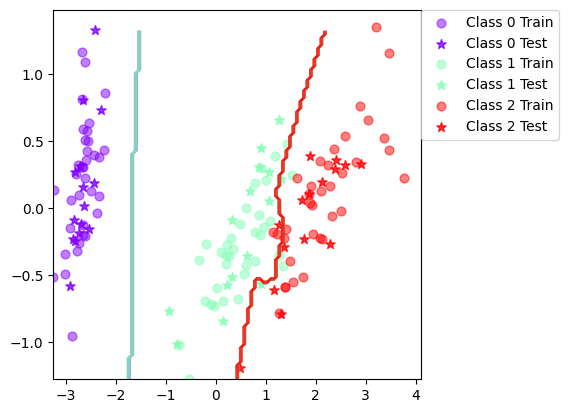

In [49]:
%matplotlib inline
plotBoundary(BoostClassifier(BayesClassifier()), dataset='iris',split=0.7)

Now repeat the steps with a decision tree classifier.

In [7]:
testClassifier(DecisionTreeClassifier(), dataset='iris', split=0.7)

Trial: 0 Accuracy 95.6
Trial: 10 Accuracy 100
Trial: 20 Accuracy 91.1
Trial: 30 Accuracy 91.1
Trial: 40 Accuracy 93.3
Trial: 50 Accuracy 91.1
Trial: 60 Accuracy 88.9
Trial: 70 Accuracy 88.9
Trial: 80 Accuracy 93.3
Trial: 90 Accuracy 88.9
Final mean classification accuracy  92.4 with standard deviation 3.71


In [8]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.7)

Trial: 0 Accuracy 95.6
Trial: 10 Accuracy 100
Trial: 20 Accuracy 95.6
Trial: 30 Accuracy 93.3
Trial: 40 Accuracy 93.3
Trial: 50 Accuracy 95.6
Trial: 60 Accuracy 88.9
Trial: 70 Accuracy 93.3
Trial: 80 Accuracy 93.3
Trial: 90 Accuracy 93.3
Final mean classification accuracy  94.6 with standard deviation 3.65


In [9]:
testClassifier(DecisionTreeClassifier(), dataset='vowel',split=0.7)

Trial: 0 Accuracy 63.6
Trial: 10 Accuracy 68.8
Trial: 20 Accuracy 63.6
Trial: 30 Accuracy 66.9
Trial: 40 Accuracy 59.7
Trial: 50 Accuracy 63
Trial: 60 Accuracy 59.7
Trial: 70 Accuracy 68.8
Trial: 80 Accuracy 59.7
Trial: 90 Accuracy 68.2
Final mean classification accuracy  64.1 with standard deviation 4


In [10]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='vowel',split=0.7)

Trial: 0 Accuracy 86.4
Trial: 10 Accuracy 89.6
Trial: 20 Accuracy 86.4
Trial: 30 Accuracy 90.9
Trial: 40 Accuracy 80.5
Trial: 50 Accuracy 81.8
Trial: 60 Accuracy 86.4
Trial: 70 Accuracy 85.1
Trial: 80 Accuracy 86.4
Trial: 90 Accuracy 89.6
Final mean classification accuracy  86.6 with standard deviation 2.85


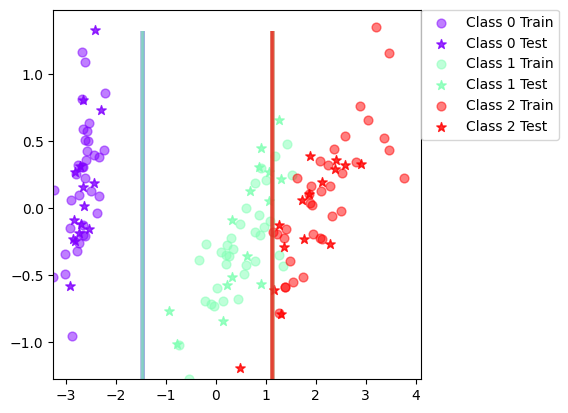

In [11]:
%matplotlib inline
plotBoundary(DecisionTreeClassifier(), dataset='iris',split=0.7)

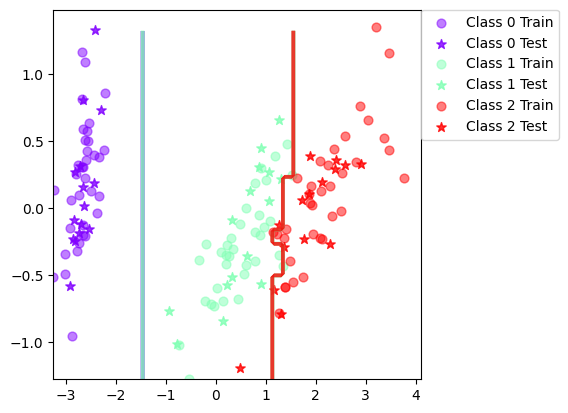

In [12]:
%matplotlib inline
plotBoundary(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.7)

## Classifying faces from Olivetti dataset

Vanilla Bayes classifier:

In [32]:
testClassifier(BayesClassifier(), dataset='olivetti',split=0.7, dim=20)

Trial: 0 Accuracy 88.3
Trial: 10 Accuracy 90.8
Trial: 20 Accuracy 85
Trial: 30 Accuracy 89.2
Trial: 40 Accuracy 89.2
Trial: 50 Accuracy 84.2
Trial: 60 Accuracy 91.7
Trial: 70 Accuracy 82.5
Trial: 80 Accuracy 81.7
Trial: 90 Accuracy 86.7
Final mean classification accuracy  87.7 with standard deviation 3.03


Boosted Bayes classifier:

In [20]:
testClassifier(BoostClassifier(BayesClassifier(), T=10), dataset='olivetti',split=0.7)

Trial: 0 Accuracy 88.3
Trial: 10 Accuracy 90.8
Trial: 20 Accuracy 85
Trial: 30 Accuracy 89.2
Trial: 40 Accuracy 89.2
Trial: 50 Accuracy 85
Trial: 60 Accuracy 91.7
Trial: 70 Accuracy 82.5
Trial: 80 Accuracy 80
Trial: 90 Accuracy 86.7
Final mean classification accuracy  87.5 with standard deviation 3.13


Boosted Decision tree classifier:

In [21]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='olivetti',split=0.7, dim=20)

Trial: 0 Accuracy 75.8
Trial: 10 Accuracy 76.7
Trial: 20 Accuracy 76.7
Trial: 30 Accuracy 68.3
Trial: 40 Accuracy 72.5
Trial: 50 Accuracy 63.3
Trial: 60 Accuracy 70.8
Trial: 70 Accuracy 54.2
Trial: 80 Accuracy 70.8
Trial: 90 Accuracy 76.7
Final mean classification accuracy  70.3 with standard deviation 6.32


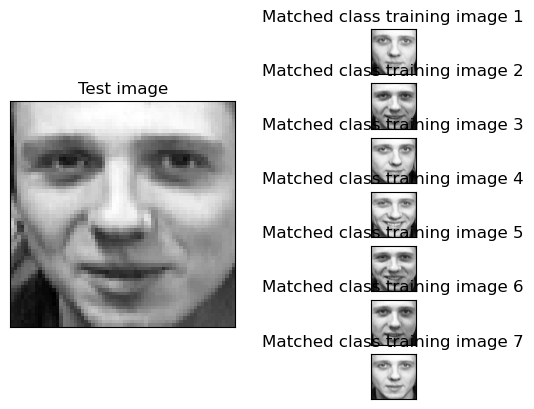

In [37]:
%matplotlib inline
X,y,pcadim = fetchDataset('olivetti') # fetch the olivetti data
xTr,yTr,xTe,yTe,trIdx,teIdx = trteSplitEven(X,y,0.7) # split into training and testing
pca = decomposition.PCA(n_components=20) # use PCA to reduce the dimension to 20
pca.fit(xTr) # use training data to fit the transform
xTrpca = pca.transform(xTr) # apply on training data
xTepca = pca.transform(xTe) # apply on test data
# boosting to classify data points in the training data
classifier = BoostClassifier(DecisionTreeClassifier(), T=10).trainClassifier(xTrpca, yTr)
yPr = classifier.classify(xTepca)
# choose a test point to visualize
testind = random.randint(0, xTe.shape[0]-1)
# visualize the test point together with the training points used to train
# the class that the test point was classified to belong to
visualizeOlivettiVectors(xTr[yTr == yPr[testind],:], xTe[testind,:])